Timestep 864.0000 ss
Run time 705.50s/11.76m


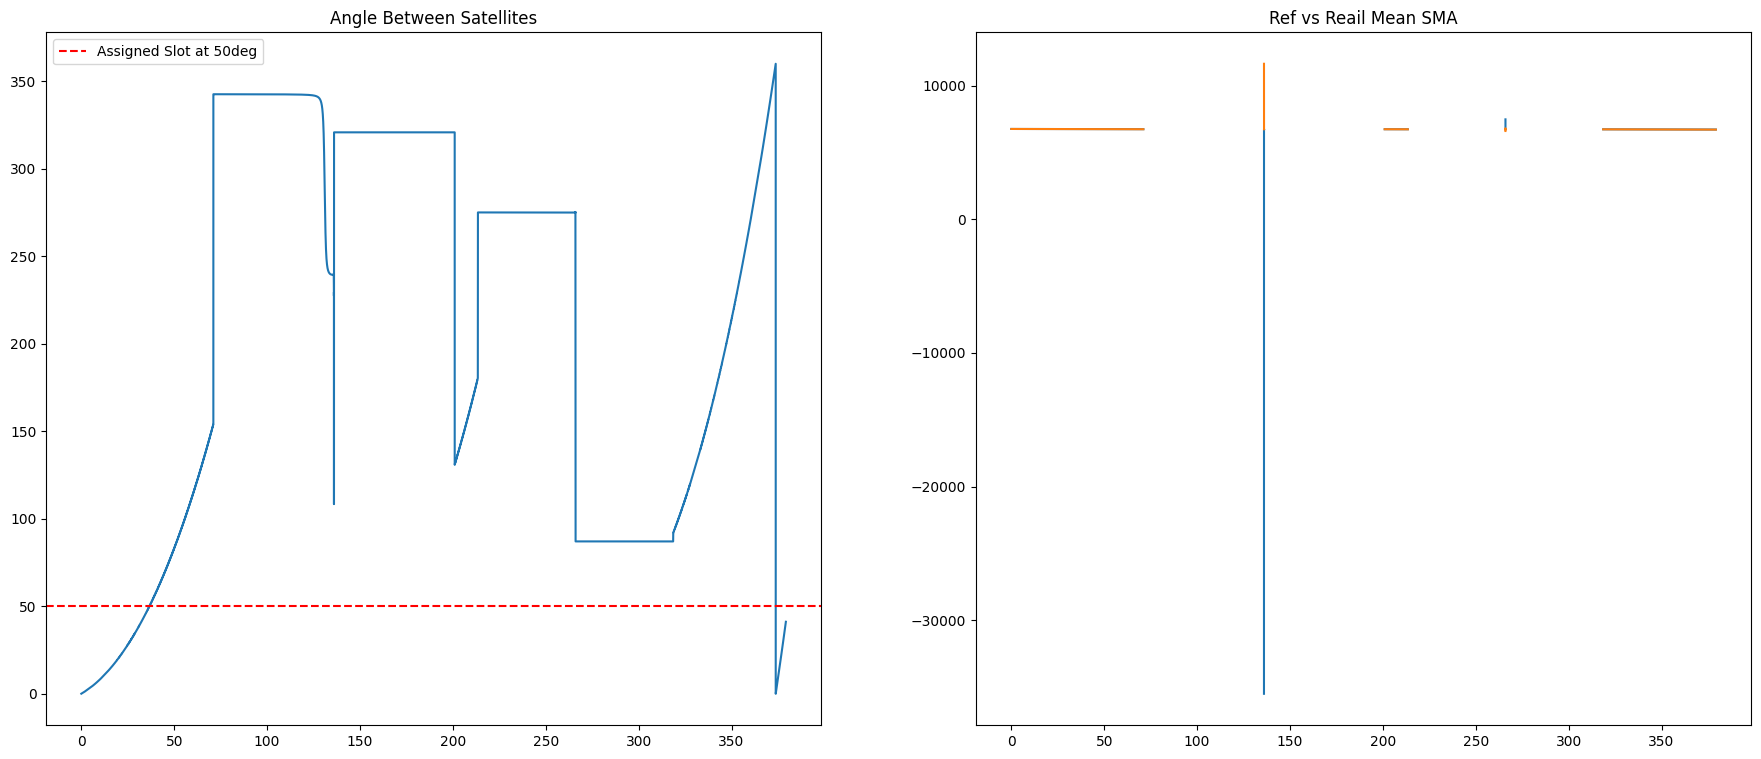

In [3]:
import numpy as np

import matplotlib.pyplot as plt

import time

from poliastro.bodies import Earth
from poliastro.twobody import Orbit
from poliastro.constants import R_earth
from poliastro.twobody.sampling import EpochsArray
from poliastro.twobody.propagation import CowellPropagator

from astropy import units as u
from astropy.time import Time, TimeDelta

from datetime import datetime
from sso_inc import inc_from_alt, raan_from_ltan, argl_difference
from perturbations import perturbations_coesa_J2_high, perturbations_coesa_J2_low, perturbations_coesa_J2_med

from osc2mean_dd import osc2mean

from scipy.optimize import line_search

toc = time.time()
## Orbit
h = 400
start_date = datetime(2024,1,1,9,0,0)
ltan = 22.5

pred_days = 100

delta_a = 0.5
delta_nu = -0.1

a = (R_earth.value/1000 + h) << u.km
ecc = 1e-6 << u.one
inc = inc_from_alt(h,ecc)[0] << u.deg   
raan = raan_from_ltan(Time(val=datetime.timestamp(start_date), format='unix'),ltan) << u.deg
argp = 1e-6 << u.deg
nu = 1e-6 << u.deg

epoch = Time(val=start_date.isoformat(), format='isot')

reference_orbit = Orbit.from_classical(
    Earth,
    a,
    ecc,
    inc,
    raan,
    argp,
    nu,
    epoch
    )
trailing_orbit = Orbit.from_classical(
    Earth,
    a+(delta_a<<u.km),
    ecc,
    inc,
    raan,
    argp,
    nu+(delta_nu<<u.deg),
    epoch
    )

# Prop
time_step = 864<<u.s

refsmalist = []
refsmalist_mean = []
trailsmalist = []
trailsmalist_mean = []

assignment = 50

elapsedsecs = []
secs = 0

angle_list = []

ref_mean = osc2mean(a.value, ecc.value, inc.value, raan.value, argp.value, nu.value)
ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, epoch)
trail_mean = osc2mean(a.value+delta_a, ecc.value, inc.value, raan.value, argp.value, nu.value+delta_nu)
trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu<<u.deg), epoch)


for i in range(5):


    theta_err = (assignment - argl_difference(reference_orbit.argp.value, reference_orbit.nu.value, trailing_orbit.argp.value, trailing_orbit.nu.value))%360

    tra_orb_10days = trail_mean_orbit.propagate(pred_days<<u.day, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_med))
    tra_10days_mean = osc2mean(tra_orb_10days.a.value, tra_orb_10days.ecc.value, tra_orb_10days.inc.to_value(u.deg), tra_orb_10days.raan.to_value(u.deg), tra_orb_10days.argp.to_value(u.deg), tra_orb_10days.nu.to_value(u.deg))
    tra_orb_10days_mean = Orbit.from_classical(Earth, tra_10days_mean[0]<<u.km, tra_10days_mean[1]<<u.one, tra_10days_mean[2]<<u.deg, tra_10days_mean[3]<<u.deg, tra_10days_mean[4]<<u.deg, tra_orb_10days.nu.to(u.deg), tra_orb_10days.epoch)

    a_err = trail_mean_orbit.a.value - ref_mean_orbit.a.value
    a_dot_rel = (trail_mean_orbit.a.value - tra_orb_10days_mean.a.value) / (pred_days*24*60*60)

    t_theta = (theta_err) / (ref_mean_orbit.n.to_value(u.deg/u.s) - trail_mean_orbit.n.to_value(u.deg/u.s))
    t_a = a_err / a_dot_rel
    t_tot = t_theta + t_a

    num_theta = int(t_theta / time_step.value)
    tofs_theta = TimeDelta(np.linspace(0, t_theta<<u.s, num=num_theta))

    num_a = int(t_a / time_step.value)
    tofs_a = TimeDelta(np.linspace(0, t_a<<u.s, num=num_a))

    if t_theta > t_a:
        trailing_ephem_sel = trailing_orbit.to_ephem(EpochsArray(epoch + tofs_theta, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_low)))
        reference_ephem_sel = reference_orbit.to_ephem(EpochsArray(epoch + tofs_theta, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_med)))
        t_prop = t_theta
    else:
        trailing_ephem_sel = trailing_orbit.to_ephem(EpochsArray(epoch + tofs_a, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_high)))  
        reference_ephem_sel = reference_orbit.to_ephem(EpochsArray(epoch + tofs_a, method=CowellPropagator(rtol=1e-5, f=perturbations_coesa_J2_med)))
        t_prop = t_a

    reference_orbit_sel = Orbit.from_ephem(Earth, reference_ephem_sel, reference_ephem_sel.epochs[-1])
    trailing_orbit_theta = Orbit.from_ephem(Earth, trailing_ephem_sel, trailing_ephem_sel.epochs[-1])

    num_prop = int(t_prop / time_step.value)
    tofs_prop = TimeDelta(np.linspace(0, t_prop<<u.s, num=num_prop))

    for t in range(len(tofs_prop)):
        secs += time_step.value

        ref_from_ephem = Orbit.from_ephem(Earth, reference_ephem_sel, reference_ephem_sel.epochs[t])
        trail_from_ephem = Orbit.from_ephem(Earth, trailing_ephem_sel, trailing_ephem_sel.epochs[t])

        elapsedsecs.append(secs)
        refsmalist.append(ref_from_ephem.a.value)
        trailsmalist.append(trail_from_ephem.a.value)

        ref_mean = osc2mean(ref_from_ephem.a.value, ref_from_ephem.ecc.value, ref_from_ephem.inc.to_value(u.deg), ref_from_ephem.raan.to_value(u.deg), ref_from_ephem.argp.to_value(u.deg), ref_from_ephem.nu.to_value(u.deg))
        trail_mean = osc2mean(trail_from_ephem.a.value, trail_from_ephem.ecc.value, trail_from_ephem.inc.to_value(u.deg), trail_from_ephem.raan.to_value(u.deg), trail_from_ephem.argp.to_value(u.deg), trail_from_ephem.nu.to_value(u.deg))

        refsmalist_mean.append(ref_mean[0])
        trailsmalist_mean.append(trail_mean[0])

        angle_list.append(argl_difference(ref_from_ephem.argp.value, ref_from_ephem.nu.value, trail_from_ephem.argp.value, trail_from_ephem.nu.value))

    reference_orbit = ref_from_ephem
    ref_mean_orbit = Orbit.from_classical(Earth, ref_mean[0]<<u.km, ref_mean[1]<<u.one, ref_mean[2]<<u.deg, ref_mean[3]<<u.deg, ref_mean[4]<<u.deg, nu, reference_orbit.epoch)

    trailing_orbit = trail_from_ephem
    trail_mean_orbit = Orbit.from_classical(Earth, trail_mean[0]<<u.km, trail_mean[1]<<u.one, trail_mean[2]<<u.deg, trail_mean[3]<<u.deg, trail_mean[4]<<u.deg, nu+(delta_nu<<u.deg), trailing_orbit.epoch)


elapsed_days = []
for sec in range(len(elapsedsecs)):
    elapsed_days.append(elapsedsecs[sec]/(60*60*24))

fig, ax = plt.subplots(1, 2, figsize=(22,9), squeeze=False) 

ax[0,0].plot(elapsed_days,angle_list)
# ax[1,1].plot(elapsedsecs,p(elapsedsecs))
ax[0,0].axhline(assignment,linestyle='--',color='red',label = f'Assigned Slot at {assignment}deg')
ax[0,0].legend(loc = 'upper left')
ax[0,0].set_title('Angle Between Satellites')

ax[0,1].plot(elapsed_days,trailsmalist_mean,label='Trail')
ax[0,1].plot(elapsed_days,refsmalist_mean,label='Ref')
ax[0,1].set_title('Ref vs Reail Mean SMA')

# plt.show(block=True)

tic = time.time()
print(f'Timestep {time_step:.4f}s')
print(f'Run time {tic-toc:.2f}s/{(tic-toc)/60:.2f}m')
plt.show()